In [1]:
#install the required packages
! pip install --upgrade scikit-learn imbalanced-learn
! pip install --upgrade scikit-learn

In [2]:
#! pip install --upgrade scikit-learn


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix, roc_curve
)
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tabulate import tabulate
import streamlit as st
import pickle


In [4]:
# Load the dataset
file_path = 'data_2021.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())


   _STATE  FMONTH        IDATE IMONTH   IDAY    IYEAR  DISPCODE  \
0     1.0     1.0  b'01192021'  b'01'  b'19'  b'2021'    1100.0   
1     1.0     1.0  b'01212021'  b'01'  b'21'  b'2021'    1100.0   
2     1.0     1.0  b'01212021'  b'01'  b'21'  b'2021'    1100.0   
3     1.0     1.0  b'01172021'  b'01'  b'17'  b'2021'    1100.0   
4     1.0     1.0  b'01152021'  b'01'  b'15'  b'2021'    1100.0   

           SEQNO          _PSU  CTELENM1  ...  _FRTRES1  _VEGRES1  _FRUTSU1  \
0  b'2021000001'  2.021000e+09       1.0  ...       1.0       1.0     100.0   
1  b'2021000002'  2.021000e+09       1.0  ...       1.0       1.0     100.0   
2  b'2021000003'  2.021000e+09       1.0  ...       1.0       1.0     100.0   
3  b'2021000004'  2.021000e+09       1.0  ...       1.0       1.0     114.0   
4  b'2021000005'  2.021000e+09       1.0  ...       1.0       1.0     100.0   

   _VEGESU1  _FRTLT1A  _VEGLT1A  _FRT16A  _VEG23A      _FRUITE1      _VEGETE1  
0     214.0       1.0       1.0      1.0  

In [5]:
data.shape

(438693, 303)

In [6]:
# Updated columns to keep with the correct sleep pattern column
columns_to_keep = [
    '_AGE_G', '_SEX', '_RACEGR3', 'EDUCA', 'INCOME3', 'EMPLOY1', 
    'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'BPHIGH6', 'TOLDHI3', 'DIABETE4', 
    'CHCCOPD3', 'CHCKDNY2', 'HAVARTH5', 'ADDEPEV3', 
    'SMOKE100', '_RFDRHV7', 'EXERANY2', '_FRTLT1A', '_VEGLT1A', '_BMI5',
    '_HLTHPLN', 'CHECKUP1', '_CHOLCH3', '_MICHD','GENHLTH','MENTHLTH','PHYSHLTH','DIFFWALK'
]

# Filter the dataset to keep only the necessary columns
cleaned_data = data[columns_to_keep]

# Display the first few rows of the cleaned dataset
cleaned_data.head()


,_AGE_G,_SEX,_RACEGR3,EDUCA,INCOME3,EMPLOY1,CVDINFR4,CVDCRHD4,CVDSTRK3,BPHIGH6,...,_VEGLT1A,_BMI5,_HLTHPLN,CHECKUP1,_CHOLCH3,_MICHD,GENHLTH,MENTHLTH,PHYSHLTH,DIFFWALK
0,6.0,2.0,1.0,4.0,5.0,7.0,2.0,2.0,2.0,3.0,...,1.0,1454.0,1.0,2.0,1.0,2.0,5.0,10.0,20.0,2.0
1,6.0,2.0,2.0,6.0,77.0,8.0,2.0,1.0,2.0,1.0,...,1.0,NaN,1.0,1.0,1.0,1.0,3.0,88.0,88.0,1.0
2,6.0,2.0,2.0,4.0,3.0,7.0,2.0,1.0,2.0,1.0,...,2.0,2829.0,1.0,1.0,1.0,1.0,2.0,88.0,88.0,2.0
3,5.0,2.0,1.0,4.0,7.0,7.0,2.0,2.0,2.0,1.0,...,1.0,3347.0,1.0,1.0,1.0,2.0,2.0,10.0,88.0,2.0
4,6.0,1.0,4.0,3.0,4.0,8.0,1.0,7.0,1.0,4.0,...,1.0,2873.0,1.0,1.0,1.0,1.0,5.0,88.0,30.0,1.0


In [7]:
cleaned_data.shape

(438693, 30)

In [8]:
# _MICHD
#Change 2 to 0 because this means did not have MI or CHD
cleaned_data['_MICHD'] = cleaned_data['_MICHD'].replace({2: 0})
cleaned_data._MICHD.unique()

/var/folders/7h/hglfzrhx0kbgrct4tg_jmq_m0000gn/T/ipykernel_80862/800341655.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['_MICHD'] = cleaned_data['_MICHD'].replace({2: 0})


array([ 0.,  1., nan])

In [9]:
#2 TOLDHI3
# Change 2 to 0 because it is No
# Remove all 7 (dont knows)
# Remove all 9 (refused)
cleaned_data['TOLDHI3'] = cleaned_data['TOLDHI3'].replace({2:0})
cleaned_data = cleaned_data[cleaned_data.TOLDHI3 != 7]
cleaned_data = cleaned_data[cleaned_data.TOLDHI3 != 9]
cleaned_data.TOLDHI3.unique()

/var/folders/7h/hglfzrhx0kbgrct4tg_jmq_m0000gn/T/ipykernel_80862/1276896058.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['TOLDHI3'] = cleaned_data['TOLDHI3'].replace({2:0})


array([ 1.,  0., nan])

In [10]:
#3 _CHOLCH3
# Change 3 to 0 and 2 to 0 for Not checked cholesterol in past 5 years
# Remove 9
cleaned_data['_CHOLCH3'] = cleaned_data['_CHOLCH3'].replace({3:0,2:0})
cleaned_data = cleaned_data[cleaned_data._CHOLCH3 != 9]
cleaned_data._CHOLCH3.unique()

array([1., 0.])

In [11]:
#4 _BMI5 (no changes, just note that these are BMI * 100. So for example a BMI of 4018 is really 40.18)
cleaned_data['_BMI5'] = cleaned_data['_BMI5'].div(100).round(0)
cleaned_data._BMI5.unique()

array([15., nan, 28., 33., 29., 24., 46., 23., 40., 27., 35., 18., 30.,
       25., 36., 22., 44., 38., 31., 45., 26., 37., 14., 21., 32., 20.,
       19., 34., 41., 43., 39., 16., 42., 50., 51., 17., 52., 47., 49.,
       56., 57., 48., 58., 61., 53., 63., 64., 54., 55., 68., 62., 13.,
       59., 89., 66., 77., 60., 87., 69., 72., 75., 67., 79., 71., 65.,
       94., 82., 86., 70., 78., 12., 74., 98., 73., 84., 76., 83., 80.,
       99., 88., 81., 92., 85., 90., 95., 91., 97.])

In [12]:
#5 SMOKE100
# Change 2 to 0 because it is No
# Remove all 7 (dont knows)
# Remove all 9 (refused)
cleaned_data['SMOKE100'] = cleaned_data['SMOKE100'].replace({2:0})
cleaned_data = cleaned_data[cleaned_data.SMOKE100 != 7]
cleaned_data = cleaned_data[cleaned_data.SMOKE100 != 9]
cleaned_data.SMOKE100.unique()

array([ 1.,  0., nan])

In [13]:
#6 CVDSTRK3
# Change 2 to 0 because it is No
# Remove all 7 (dont knows)
# Remove all 9 (refused)
cleaned_data['CVDSTRK3'] = cleaned_data['CVDSTRK3'].replace({2:0})
cleaned_data = cleaned_data[cleaned_data.CVDSTRK3 != 7]
cleaned_data = cleaned_data[cleaned_data.CVDSTRK3 != 9]
cleaned_data.CVDSTRK3.unique()

array([0., 1.])

In [14]:
#7 DIABETE4
# going to make this ordinal. 0 is for no diabetes or only during pregnancy, 1 is for pre-diabetes or borderline diabetes, 2 is for yes diabetes
# Remove all 7 (dont knows)
# Remove all 9 (refused)
cleaned_data['DIABETE4'] = cleaned_data['DIABETE4'].replace({2:0, 3:0, 1:2, 4:1})
cleaned_data = cleaned_data[cleaned_data.DIABETE4 != 7]
cleaned_data = cleaned_data[cleaned_data.DIABETE4 != 9]
cleaned_data.DIABETE4.unique()

array([ 0.,  2.,  1., nan])

In [15]:
#9 _FRTLT1A
# Change 2 to 0. this means no fruit consumed per day. 1 will mean consumed 1 or more pieces of fruit per day 
# remove all dont knows and missing 9
cleaned_data['_FRTLT1A'] = cleaned_data['_FRTLT1A'].replace({2:0})
cleaned_data = cleaned_data[cleaned_data._FRTLT1A != 9]
cleaned_data._FRTLT1A.unique()

array([1., 0.])

In [16]:
#10 _VEGLT1A
# Change 2 to 0. this means no vegetables consumed per day. 1 will mean consumed 1 or more pieces of vegetable per day 
# remove all dont knows and missing 9
cleaned_data['_VEGLT1A'] = cleaned_data['_VEGLT1A'].replace({2:0})
cleaned_data = cleaned_data[cleaned_data._VEGLT1A != 9]
cleaned_data._VEGLT1A.unique()

array([1., 0.])

In [17]:
#11 _RFDRHV7
# Change 1 to 0 (1 was no for heavy drinking). change all 2 to 1 (2 was yes for heavy drinking)
# remove all dont knows and missing 9
cleaned_data['_RFDRHV7'] = cleaned_data['_RFDRHV7'].replace({1:0, 2:1})
cleaned_data = cleaned_data[cleaned_data._RFDRHV7 != 9]
cleaned_data._RFDRHV7.unique()

array([0., 1.])

In [18]:
#12 _HLTHPLN
# 1 is yes, change 2 to 0 because it is No health care access
# remove 7 and 9 for don't know or refused
cleaned_data['_HLTHPLN'] = cleaned_data['_HLTHPLN'].replace({2:0})
cleaned_data = cleaned_data[cleaned_data._HLTHPLN != 7]
cleaned_data = cleaned_data[cleaned_data._HLTHPLN != 9]
cleaned_data._HLTHPLN.unique()

array([1., 0.])

In [19]:
#14 GENHLTH
# This is an ordinal variable that I want to keep (1 is Excellent -> 5 is Poor)
# Remove 7 and 9 for don't know and refused
cleaned_data = cleaned_data[cleaned_data.GENHLTH != 7]
cleaned_data = cleaned_data[cleaned_data.GENHLTH != 9]
cleaned_data.GENHLTH.unique()


array([ 5.,  3.,  2.,  4.,  1., nan])

In [20]:
#15 MENTHLTH
# already in days so keep that, scale will be 0-30
# change 88 to 0 because it means none (no bad mental health days)
# remove 77 and 99 for don't know not sure and refused
cleaned_data['MENTHLTH'] = cleaned_data['MENTHLTH'].replace({88:0})
cleaned_data = cleaned_data[cleaned_data.MENTHLTH != 77]
cleaned_data = cleaned_data[cleaned_data.MENTHLTH != 99]
cleaned_data.MENTHLTH.unique()

array([10.,  0.,  5., 25., 14.,  2.,  3.,  7., 30., 15., 20.,  8.,  1.,
        4., 28., 24., 21., 12.,  6., 22., 27., 18., 13., 17., 16.,  9.,
       19., 29., 23., 11., 26.])

In [21]:
#16 PHYSHLTH
# already in days so keep that, scale will be 0-30
# change 88 to 0 because it means none (no bad mental health days)
# remove 77 and 99 for don't know not sure and refused
cleaned_data['PHYSHLTH'] = cleaned_data['PHYSHLTH'].replace({88:0})
cleaned_data = cleaned_data[cleaned_data.PHYSHLTH != 77]
cleaned_data = cleaned_data[cleaned_data.PHYSHLTH != 99]
cleaned_data.PHYSHLTH.unique()

array([20.,  0., 30., 25.,  1.,  4., 10.,  2.,  3., 15.,  8., 13., 14.,
        5.,  7.,  6., 12., 24., 29., 18.,  9., 16., 17., 26., 28., 21.,
       27., 11., 19., 22., 23., nan])

In [22]:
#17 DIFFWALK
# change 2 to 0 for no. 1 is already yes
# remove 7 and 9 for don't know not sure and refused
cleaned_data['DIFFWALK'] = cleaned_data['DIFFWALK'].replace({2:0})
cleaned_data = cleaned_data[cleaned_data.DIFFWALK != 7]
cleaned_data = cleaned_data[cleaned_data.DIFFWALK != 9]
cleaned_data.DIFFWALK.unique()

array([0., 1.])

In [23]:
#18 SEX
# in other words - is respondent male (somewhat arbitrarily chose this change because men are at higher risk for heart disease)
# change 2 to 0 (female as 0). Male is 1
cleaned_data['_SEX'] = cleaned_data['_SEX'].replace({2:0})
cleaned_data._SEX.unique()

array([0., 1.])

In [24]:
#20 EDUCA
# This is already an ordinal variable with 1 being never attended school or kindergarten only up to 6 being college 4 years or more
# Scale here is 1-6
# Remove 9 for refused:
cleaned_data = cleaned_data[cleaned_data.EDUCA != 9]
cleaned_data.EDUCA.unique()

array([4., 6., 3., 5., 2., 1.])

In [25]:
#21 INCOME3
# Variable is already ordinal with 1 being less than $10,000 all the way up to 8 being $75,000 or more
# Remove 77 and 99 for don't know and refused
cleaned_data = cleaned_data[cleaned_data.INCOME3 != 77]
cleaned_data = cleaned_data[cleaned_data.INCOME3 != 99]
cleaned_data.INCOME3.unique()

array([ 5.,  3.,  7.,  4.,  6.,  8.,  2.,  9., 10.,  1., 11., nan])

In [26]:
#22 CVDCRHD4
# 1 is yes, change 2 to 0 because it is No heart disease
# remove 7 and 9 for don't know or refused
cleaned_data['CVDCRHD4'] = cleaned_data['CVDCRHD4'].replace({2:0})
cleaned_data = cleaned_data[cleaned_data.CVDCRHD4 != 7]
cleaned_data = cleaned_data[cleaned_data.CVDCRHD4 != 9]
cleaned_data.CVDCRHD4.unique()

array([0., 1.])

In [27]:
#23 CVDINFR4
# 1 is yes, change 2 to 0 because it is No heart attack
# remove 7 and 9 for don't know or refused
cleaned_data['CVDINFR4'] = cleaned_data['CVDINFR4'].replace({2:0})
cleaned_data = cleaned_data[cleaned_data.CVDINFR4 != 7]
cleaned_data = cleaned_data[cleaned_data.CVDINFR4 != 9]
cleaned_data.CVDINFR4.unique()

array([0., 1.])

In [28]:
#24 CHCCOPD3
# 1 is yes, change 2 to 0 because it is No heart attack
# remove 7 and 9 for don't know or refused
cleaned_data['CHCCOPD3'] = cleaned_data['CHCCOPD3'].replace({2:0})
cleaned_data = cleaned_data[cleaned_data.CHCCOPD3 != 7]
cleaned_data = cleaned_data[cleaned_data.CHCCOPD3 != 9]
cleaned_data.CHCCOPD3.unique()

array([1., 0.])

In [29]:
#25 CHCKDNY2
# 1 is yes, change 2 to 0 because it is No kidney disease
# remove 7 and 9 for don't know or refused
cleaned_data['CHCKDNY2'] = cleaned_data['CHCKDNY2'].replace({2:0})
cleaned_data = cleaned_data[cleaned_data.CHCKDNY2 != 7]
cleaned_data = cleaned_data[cleaned_data.CHCKDNY2 != 9]
cleaned_data.CHCKDNY2.unique()

array([0., 1.])

In [30]:
#26 HAVARTH5
# 1 is yes, change 2 to 0 because it is No arthritis
# remove 7 and 9 for don't know or refused
cleaned_data['HAVARTH5'] = cleaned_data['HAVARTH5'].replace({2:0})
cleaned_data = cleaned_data[cleaned_data.HAVARTH5 != 7]
cleaned_data = cleaned_data[cleaned_data.HAVARTH5 != 9]
cleaned_data.HAVARTH5.unique()

array([1., 0.])

In [31]:
#27 ADDEPEV3
# 1 is yes, change 2 to 0 because it is No  depressive disorder 
# remove 7 and 9 for don't know or refused
cleaned_data['ADDEPEV3'] = cleaned_data['ADDEPEV3'].replace({2:0})
cleaned_data = cleaned_data[cleaned_data.ADDEPEV3 != 7]
cleaned_data = cleaned_data[cleaned_data.ADDEPEV3 != 9]
cleaned_data.ADDEPEV3.unique()

array([0., 1.])

In [32]:
#28 EXERANY2
# 1 is yes, change 2 to 0 because it is No  excercise
# remove 7 and 9 for don't know or refused
cleaned_data['EXERANY2'] = cleaned_data['EXERANY2'].replace({2:0})
cleaned_data = cleaned_data[cleaned_data.EXERANY2 != 7]
cleaned_data = cleaned_data[cleaned_data.EXERANY2 != 9]
cleaned_data.EXERANY2.unique()

array([0., 1.])

In [33]:
#29 BPHIGH6
# 1 is yes, change 2 to 0 because it is No  excercise
# remove 7 and 9 for don't know or refused
#cleaned_data['BPHIGH6'] = cleaned_data['BPHIGH6'].replace({3:0})
#cleaned_data['BPHIGH6'] = cleaned_data['BPHIGH6'].replace({2:1})
#cleaned_data['BPHIGH6'] = cleaned_data['BPHIGH6'].replace({4:2})
#cleaned_data = cleaned_data[cleaned_data.EXERANY2 != 7]
#cleaned_data = cleaned_data[cleaned_data.EXERANY2 != 9]
#cleaned_data.EXERANY2.unique()

In [34]:
cleaned_data.head()

,_AGE_G,_SEX,_RACEGR3,EDUCA,INCOME3,EMPLOY1,CVDINFR4,CVDCRHD4,CVDSTRK3,BPHIGH6,...,_VEGLT1A,_BMI5,_HLTHPLN,CHECKUP1,_CHOLCH3,_MICHD,GENHLTH,MENTHLTH,PHYSHLTH,DIFFWALK
0,6.0,0.0,1.0,4.0,5.0,7.0,0.0,0.0,0.0,3.0,...,1.0,15.0,1.0,2.0,1.0,0.0,5.0,10.0,20.0,0.0
2,6.0,0.0,2.0,4.0,3.0,7.0,0.0,1.0,0.0,1.0,...,0.0,28.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0
3,5.0,0.0,1.0,4.0,7.0,7.0,0.0,0.0,0.0,1.0,...,1.0,33.0,1.0,1.0,1.0,0.0,2.0,10.0,0.0,0.0
5,6.0,1.0,1.0,5.0,6.0,7.0,0.0,0.0,0.0,3.0,...,0.0,24.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0
9,6.0,0.0,1.0,4.0,8.0,7.0,0.0,0.0,0.0,1.0,...,1.0,40.0,1.0,1.0,1.0,0.0,3.0,5.0,25.0,1.0


In [35]:
# Renaming the columns to more meaningful names
renamed_columns = {
    '_AGE_G': 'Age_Group',
    '_SEX': 'Sex',
    '_RACEGR3': 'Race_Ethnicity',
    'EDUCA': 'Education_Level',
    'INCOME3': 'Income_Level',
    'EMPLOY1': 'Employment_Status',
    'CVDINFR4': 'Heart_Attack',
    'CVDCRHD4': 'Coronary_Heart_Disease',
    'CVDSTRK3': 'Stroke',
    'BPHIGH6': 'High_Blood_Pressure',
    'TOLDHI3': 'High_Cholesterol',
    'DIABETE4': 'Diabetes',
    'CHCCOPD3': 'chronic_bronchitis',
    'CHCKDNY2': 'Kidney_Disease',
    'HAVARTH5': 'Arthritis',
    'ADDEPEV3': 'Depression',
    'SMOKE100': 'Smoked_100_Cigarettes',
    '_RFDRHV7': 'Alcohol_Consumption',
    'EXERANY2': 'Physical_Activity',
    '_FRTLT1A': 'Fruit_Consumption',
    '_VEGLT1A': 'Vegetable_Consumption',
    '_BMI5': 'BMI',
    '_HLTHPLN': 'Health_Care_Coverage',
    'CHECKUP1': 'Routine_Checkup',
    '_CHOLCH3': 'Cholesterol_Check',
    '_MICHD': 'Heart_Disease',
    'GENHLTH': 'General_Health',
    'MENTHLTH': 'Mental_Health',
    'PHYSHLTH': 'Physical_Health',
    'DIFFWALK': 'Difficuty_Walking'
}

# Renaming the columns
data = cleaned_data.rename(columns=renamed_columns)

# Save the renamed dataset to a new CSV file
data.to_csv('cleaned_and_renamed_2021.csv', index=False)

# Display the first few rows of the renamed dataset
data.head()


,Age_Group,Sex,Race_Ethnicity,Education_Level,Income_Level,Employment_Status,Heart_Attack,Coronary_Heart_Disease,Stroke,High_Blood_Pressure,...,Vegetable_Consumption,BMI,Health_Care_Coverage,Routine_Checkup,Cholesterol_Check,Heart_Disease,General_Health,Mental_Health,Physical_Health,Difficuty_Walking
0,6.0,0.0,1.0,4.0,5.0,7.0,0.0,0.0,0.0,3.0,...,1.0,15.0,1.0,2.0,1.0,0.0,5.0,10.0,20.0,0.0
2,6.0,0.0,2.0,4.0,3.0,7.0,0.0,1.0,0.0,1.0,...,0.0,28.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0
3,5.0,0.0,1.0,4.0,7.0,7.0,0.0,0.0,0.0,1.0,...,1.0,33.0,1.0,1.0,1.0,0.0,2.0,10.0,0.0,0.0
5,6.0,1.0,1.0,5.0,6.0,7.0,0.0,0.0,0.0,3.0,...,0.0,24.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0
9,6.0,0.0,1.0,4.0,8.0,7.0,0.0,0.0,0.0,1.0,...,1.0,40.0,1.0,1.0,1.0,0.0,3.0,5.0,25.0,1.0


In [36]:
# Check for missing values and data types
missing_values = data.isnull().sum()
data_types = data.dtypes

missing_values, data_types

(Age_Group                     0
 Sex                           0
 Race_Ethnicity                0
 Education_Level               0
 Income_Level                  6
 Employment_Status             1
 Heart_Attack                  0
 Coronary_Heart_Disease        0
 Stroke                        0
 High_Blood_Pressure           0
 High_Cholesterol          18949
 Diabetes                      0
 chronic_bronchitis            0
 Kidney_Disease                0
 Arthritis                     0
 Depression                    0
 Smoked_100_Cigarettes         0
 Alcohol_Consumption           0
 Physical_Activity             0
 Fruit_Consumption             0
 Vegetable_Consumption         0
 BMI                       11575
 Health_Care_Coverage          0
 Routine_Checkup               0
 Cholesterol_Check             0
 Heart_Disease                 0
 General_Health                1
 Mental_Health                 0
 Physical_Health               2
 Difficuty_Walking             0
 dtype: in

In [37]:
# Handling missing values

In [38]:

# Handling missing values

# 1. Fill missing values for categorical variables with mode
categorical_columns = ['Sex', 'Race_Ethnicity', 'Education_Level', 'Employment_Status', 
                       'Health_Care_Coverage', 'Routine_Checkup']
for col in categorical_columns:
    mode_value = data[col].mode()[0]
    data[col].fillna(mode_value, inplace=True)

# 2. Check skewness and fill missing values for numerical variables
numerical_columns = ['Income_Level', 'Heart_Attack', 'Coronary_Heart_Disease', 'Stroke', 
                     'High_Blood_Pressure', 'High_Cholesterol', 'Diabetes', 'chronic_bronchitis', 
                     'Kidney_Disease', 'Arthritis', 'Depression', 'Smoked_100_Cigarettes', 
                     'Alcohol_Consumption', 'Physical_Activity', 'Fruit_Consumption', 
                     'Vegetable_Consumption', 'BMI', 'Cholesterol_Check', 'Heart_Disease']

# Calculate skewness
skewness = data[numerical_columns].skew()

# Fill missing values based on skewness
for col in numerical_columns:
    if abs(skewness[col]) > 1:
        # High skewness, use median
        median_value = data[col].median()
        data[col].fillna(median_value, inplace=True)
    else:
        # Low skewness, use mean
        mean_value = data[col].mean()
        data[col].fillna(mean_value, inplace=True)

# 3. Convert data types for categorical columns to 'category'
data[categorical_columns] = data[categorical_columns].astype('category')

# Check if missing values are handled
missing_values_after = data.isnull().sum()

missing_values_after

Age_Group                 0
Sex                       0
Race_Ethnicity            0
Education_Level           0
Income_Level              0
Employment_Status         0
Heart_Attack              0
Coronary_Heart_Disease    0
Stroke                    0
High_Blood_Pressure       0
High_Cholesterol          0
Diabetes                  0
chronic_bronchitis        0
Kidney_Disease            0
Arthritis                 0
Depression                0
Smoked_100_Cigarettes     0
Alcohol_Consumption       0
Physical_Activity         0
Fruit_Consumption         0
Vegetable_Consumption     0
BMI                       0
Health_Care_Coverage      0
Routine_Checkup           0
Cholesterol_Check         0
Heart_Disease             0
General_Health            1
Mental_Health             0
Physical_Health           2
Difficuty_Walking         0
dtype: int64

In [39]:
columns_with_missing = ['General_Health', 'Physical_Health']

# Create an imputer object with the mean strategy
imputer = SimpleImputer(strategy='mean')

# Impute the missing values in both columns
data[columns_with_missing] = imputer.fit_transform(data[columns_with_missing])

# Check if the missing values are imputed
print(data.isnull().sum())

Age_Group                 0
Sex                       0
Race_Ethnicity            0
Education_Level           0
Income_Level              0
Employment_Status         0
Heart_Attack              0
Coronary_Heart_Disease    0
Stroke                    0
High_Blood_Pressure       0
High_Cholesterol          0
Diabetes                  0
chronic_bronchitis        0
Kidney_Disease            0
Arthritis                 0
Depression                0
Smoked_100_Cigarettes     0
Alcohol_Consumption       0
Physical_Activity         0
Fruit_Consumption         0
Vegetable_Consumption     0
BMI                       0
Health_Care_Coverage      0
Routine_Checkup           0
Cholesterol_Check         0
Heart_Disease             0
General_Health            0
Mental_Health             0
Physical_Health           0
Difficuty_Walking         0
dtype: int64


In [40]:
data.shape

(264821, 30)

In [41]:
#EDA

In [42]:
data.to_csv("eda_data.csv")

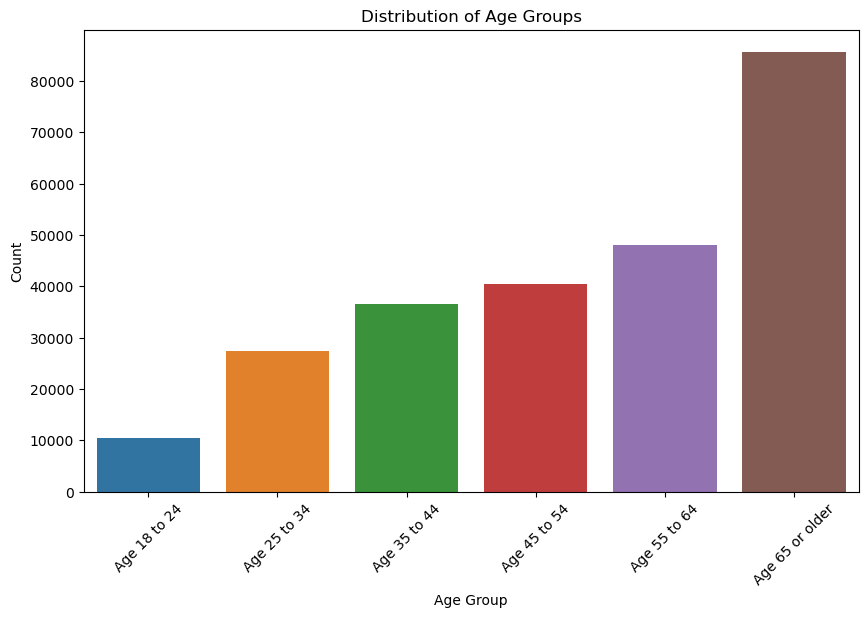

In [66]:
# Define the labels for different age groups
age_group_labels = [
    'Age 18 to 24',
    'Age 25 to 34',
    'Age 35 to 44',
    'Age 45 to 54',
    'Age 55 to 64',
    'Age 65 or older'
]

# Create a figure with a specific size for the plot
plt.figure(figsize=(10, 6))

# Create a count plot for the 'Age_Group' column in the dataset
sns.countplot(x='Age_Group', data=data)

# Set the title of the plot
plt.title('Distribution of Age Groups')

# Label the x-axis as 'Age Group'
plt.xlabel('Age Group')

# Label the y-axis as 'Count'
plt.ylabel('Count')

# Set custom labels and rotate them by 45 degrees for better readability
plt.xticks(ticks=range(6), labels=age_group_labels, rotation=45)

# Display the plot
plt.show()


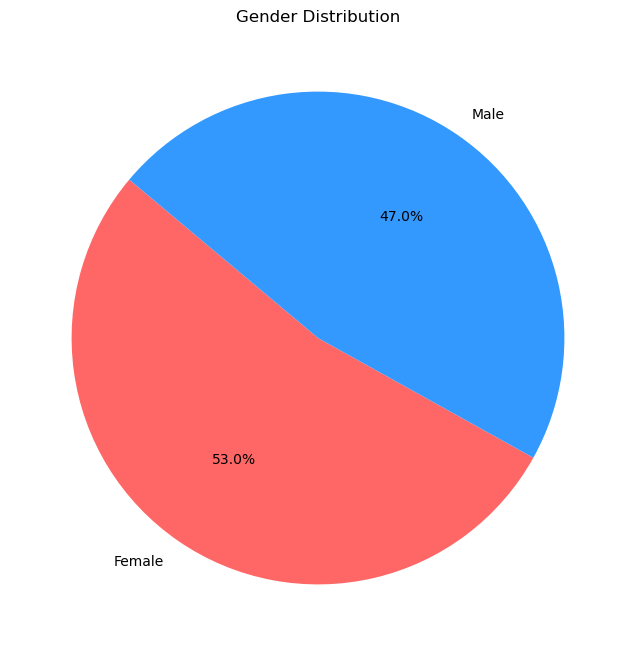

In [44]:
# Gender Distribution - Pie Chart
gender_counts = data['Sex'].value_counts()
gender_labels = ['Female', 'Male']

plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_labels, autopct='%1.1f%%', startangle=140, colors=['#ff6666','#3399ff'])
plt.title('Gender Distribution')
plt.show()

/var/folders/7h/hglfzrhx0kbgrct4tg_jmq_m0000gn/T/ipykernel_80862/1571069824.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


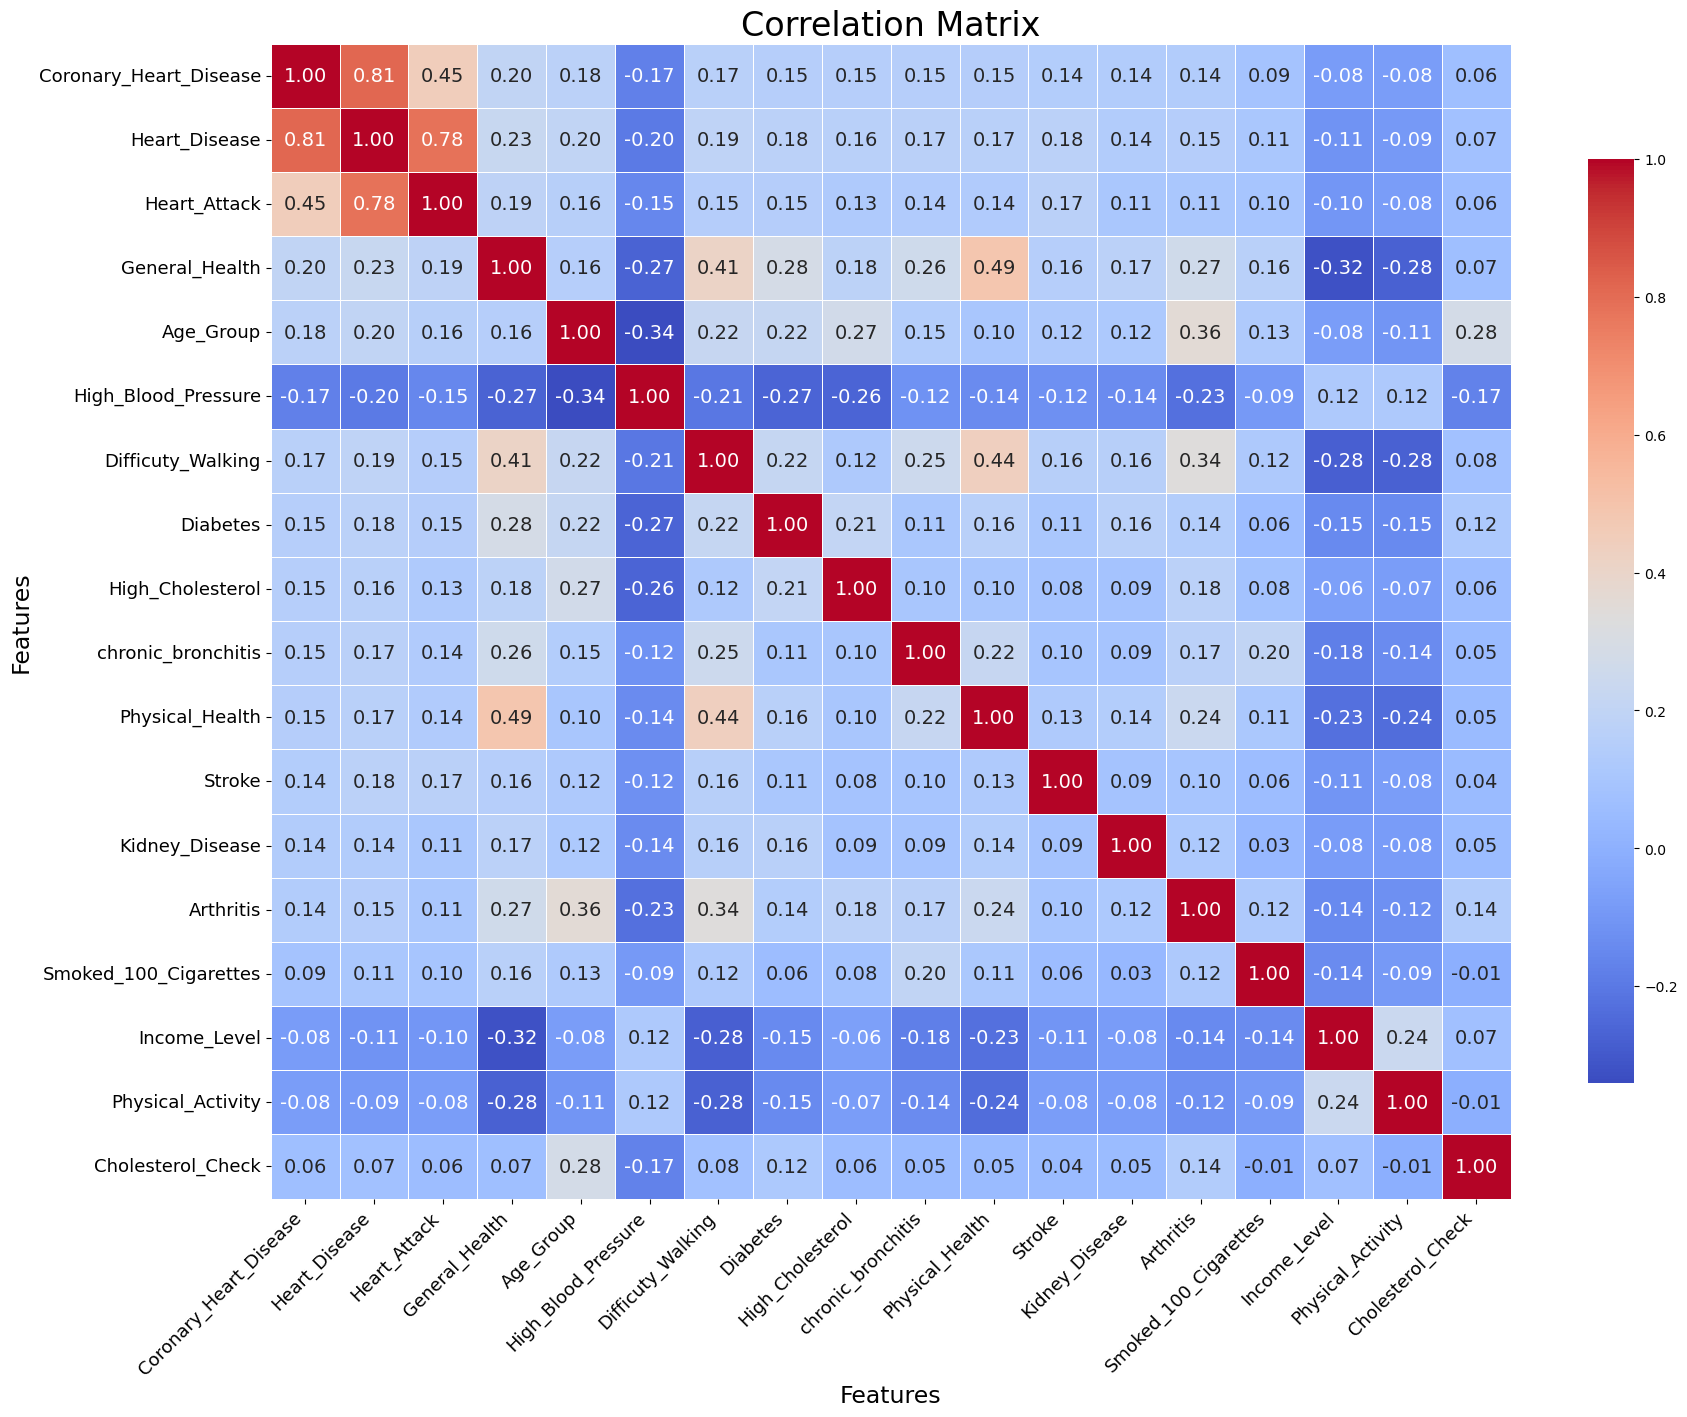

In [46]:


# Calculate the correlation matrix
correlation_matrix = data.corr()

# Extract correlations with the target variable and sort them
target_corr = correlation_matrix["Coronary_Heart_Disease"].abs().sort_values(ascending=False)

# Reorder the entire correlation matrix based on the target correlations
ordered_corr_matrix = correlation_matrix.loc[target_corr.index, target_corr.index]

# Remove the last 6 features
trimmed_corr_matrix = ordered_corr_matrix.iloc[:-6, :-6]

# Visualize the trimmed correlation matrix using a heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(trimmed_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={'shrink': 0.8},  # Shrink the color bar a bit
            annot_kws={"size": 14},  # Increase the font size of the annotations
            linewidths=.5)

# Set the font size for axis labels and titles
plt.title('Correlation Matrix', fontsize=24)
plt.xticks(fontsize=13, rotation=45, ha='right')  # Rotate and align the x labels
plt.yticks(fontsize=13, rotation=0)  # y labels remain horizontal
plt.xlabel('Features', fontsize=17)
plt.ylabel('Features', fontsize=17)
plt.show()


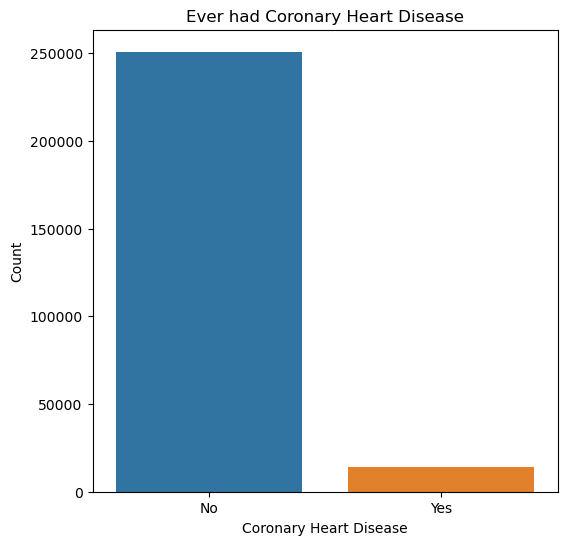

In [47]:
# Display the plot for presense of CHD

chd_labels = ['No', 'Yes']

plt.figure(figsize=(6, 6))
sns.countplot(x='Coronary_Heart_Disease', data=data)
plt.title('Ever had Coronary Heart Disease')
plt.xlabel('Coronary Heart Disease')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=chd_labels)
plt.show()


In [49]:
#Feature Importances

Feature Importance from Random Forest:
                  Feature  Importance
24          Heart_Disease    0.556223
6            Heart_Attack    0.133503
20                    BMI    0.040478
4            Income_Level    0.029957
25         General_Health    0.022671
27        Physical_Health    0.020109
0               Age_Group    0.017014
3         Education_Level    0.016914
26          Mental_Health    0.015488
5       Employment_Status    0.015224
9        High_Cholesterol    0.010984
8     High_Blood_Pressure    0.010212
2          Race_Ethnicity    0.010075
10               Diabetes    0.009818
18      Fruit_Consumption    0.008794
13              Arthritis    0.008232
1                     Sex    0.008231
15  Smoked_100_Cigarettes    0.008024
17      Physical_Activity    0.007893
28      Difficuty_Walking    0.007459
11     chronic_bronchitis    0.006880
19  Vegetable_Consumption    0.006880
7                  Stroke    0.006629
14             Depression    0.005784
12         

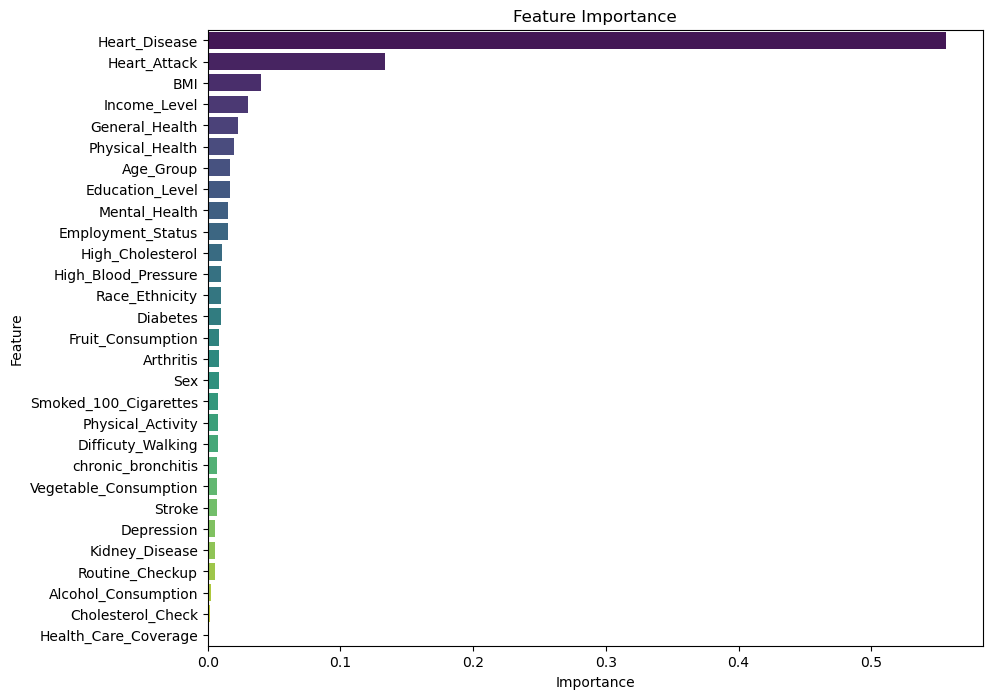

In [50]:

# Load the dataset
data = pd.read_csv('imbdata.csv')

# Dropping unnecessary columns if any
data_clean = data.drop(columns=['Unnamed: 0'])  # Assuming 'Unnamed: 0' is an index column

# Define the target variable and features
X = data_clean.drop(columns=['Coronary_Heart_Disease'])  # Features
y = data_clean['Coronary_Heart_Disease']  # Target variable

# Handle any missing values by filling with mean (if applicable)
X = X.fillna(X.mean())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train a Random Forest model to determine feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)


# Displaying the results
print("Feature Importance from Random Forest:")
print(importance_df)

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()



In [51]:
 # Calculate Variance Inflation Factor (VIF) for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

print("\nVariance Inflation Factor (VIF):")
print(vif_data.sort_values(by='VIF', ascending=False))


Variance Inflation Factor (VIF):
                  Feature       VIF
24          Heart_Disease  2.710832
6            Heart_Attack  2.583530
0               Age_Group  1.932459
5       Employment_Status  1.614236
25         General_Health  1.580719
4            Income_Level  1.465618
28      Difficuty_Walking  1.400200
27        Physical_Health  1.386189
23      Cholesterol_Check  1.349307
22        Routine_Checkup  1.344428
8     High_Blood_Pressure  1.333694
26          Mental_Health  1.299625
3         Education_Level  1.292816
13              Arthritis  1.291677
14             Depression  1.233038
10               Diabetes  1.203050
20                    BMI  1.168366
17      Physical_Activity  1.166187
9        High_Cholesterol  1.162970
21   Health_Care_Coverage  1.144112
11     chronic_bronchitis  1.128121
15  Smoked_100_Cigarettes  1.123084
1                     Sex  1.100799
2          Race_Ethnicity  1.097024
19  Vegetable_Consumption  1.087208
18      Fruit_Consumption  1.0

In [53]:
heart_data = data.copy()

In [54]:
imb_data = data.copy()

In [55]:
heart_data.shape

(248780, 31)

In [56]:
#loading the cleaned dataframe to new csv to use it for model training and evaluation
data.to_csv("imbdata1.csv")

# IMB Data

In [59]:
#class imbalance
# Load the dataset
data = pd.read_csv('imbdata1.csv')

# Data preprocessing
data.fillna(data.median(), inplace=True)

# Exclude 'Heart_Attack' and 'Heart_Disease' due to high correlation with the target
selected_features = ['Age_Group', 'Employment_Status', 'Stroke', 'High_Blood_Pressure', 
                     'High_Cholesterol', 'Diabetes', 'chronic_bronchitis', 'Kidney_Disease', 
                     'Arthritis', 'General_Health', 'Physical_Health', 'Difficuty_Walking',
                     'Smoked_100_Cigarettes' ,'BMI','Sex'
                    ]

# Feature and target separation using selected features
X = data[selected_features]
y = data['Coronary_Heart_Disease']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Note: Scaling test data using the training scaler

# Initialize individual classifiers without class balancing
log_reg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Combine classifiers into a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('rf_clf', rf_clf),
        ('xgb_clf', xgb_clf)
    ],
    voting='soft'  # Use 'hard' for hard voting
)

# Train and evaluate each model
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf_clf,
    'XGBoost': xgb_clf,
    'Voting Classifier': voting_clf
}

results = []

for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Extract metrics from classification report
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']
    f1_score = class_report['weighted avg']['f1-score']
    
    # Collect results
    results.append({
        'Model': name,
        'Accuracy': f"{accuracy:.5f}",
        'Precision': f"{precision:.5f}",
        'Recall': f"{recall:.5f}",
        'F1-Score': f"{f1_score:.5f}",
        'ROC-AUC Score': f"{roc_auc:.5f}" if roc_auc is not None else 'N/A'
    })

# Print results in tabular format
print(tabulate(results, headers="keys", tablefmt="grid", showindex=False))


/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:06:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:07:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+---------------------+------------+-------------+----------+------------+-----------------+
| Model               |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC Score |
+=====================+============+=============+==========+============+=================+
| Logistic Regression |    0.95096 |     0.93038 |  0.95096 |    0.93086 |         0.85967 |
+---------------------+------------+-------------+----------+------------+-----------------+
| Random Forest       |    0.94355 |     0.92028 |  0.94355 |    0.92938 |         0.78783 |
+---------------------+------------+-------------+----------+------------+-----------------+
| XGBoost             |    0.95079 |     0.92939 |  0.95079 |    0.93074 |         0.85399 |
+---------------------+------------+-------------+----------+------------+-----------------+
| Voting Classifier   |    0.95084 |     0.92933 |  0.95084 |    0.93034 |         0.85396 |
+---------------------+------------+-------------+----------+---------

In [60]:
#undersampling

# Load the dataset
data = pd.read_csv('imbdata1.csv')

# Data preprocessing
data.fillna(data.median(), inplace=True)

# Exclude 'Heart_Attack' and 'Heart_Disease' due to high correlation with the target
selected_features = ['Age_Group', 'Employment_Status', 'Stroke', 'High_Blood_Pressure', 
                     'High_Cholesterol', 'Diabetes', 'chronic_bronchitis', 'Kidney_Disease', 
                     'Arthritis', 'General_Health', 'Physical_Health', 'Difficuty_Walking',
                     'Smoked_100_Cigarettes' ,'BMI','Sex'
                    ]

# Feature and target separation using selected features
X = data[selected_features]
y = data['Coronary_Heart_Disease']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply Random Under Sampling to handle class imbalance in the training set
undersample = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)

# Feature scaling
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Note: Scaling test data using the training scaler

# Initialize individual classifiers
log_reg = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=1,
    random_state=42
)

# Combine classifiers into a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('rf_clf', rf_clf),
        ('xgb_clf', xgb_clf)
    ],
    voting='soft'  # Use 'hard' for hard voting
)

# Train and evaluate each model
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf_clf,
    'XGBoost': xgb_clf,
    'Voting Classifier': voting_clf
}

results = []

for name, model in models.items():
    # Train the model
    model.fit(X_train_resampled_scaled, y_train_resampled)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Extract metrics from classification report
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']
    f1_score = class_report['weighted avg']['f1-score']
    
    # Collect results
    results.append({
        'Model': name,
        'Accuracy': f"{accuracy:.5f}",
        'Precision': f"{precision:.5f}",
        'Recall': f"{recall:.5f}",
        'F1-Score': f"{f1_score:.5f}",
        'ROC-AUC Score': f"{roc_auc:.5f}" if roc_auc is not None else 'N/A'
    })

# Print results in tabular format
print(tabulate(results, headers="keys", tablefmt="grid", showindex=False))
    

/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:07:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:07:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+---------------------+------------+-------------+----------+------------+-----------------+
| Model               |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC Score |
+=====================+============+=============+==========+============+=================+
| Logistic Regression |    0.75811 |     0.94585 |  0.75811 |    0.82608 |         0.86009 |
+---------------------+------------+-------------+----------+------------+-----------------+
| Random Forest       |    0.72768 |     0.94352 |  0.72768 |    0.80493 |         0.82536 |
+---------------------+------------+-------------+----------+------------+-----------------+
| XGBoost             |    0.73736 |     0.94556 |  0.73736 |    0.81174 |         0.84981 |
+---------------------+------------+-------------+----------+------------+-----------------+
| Voting Classifier   |    0.74453 |     0.94602 |  0.74453 |    0.81674 |         0.85629 |
+---------------------+------------+-------------+----------+---------

In [61]:

#Oversample

# Load the dataset
data = pd.read_csv('imbdata1.csv')

# Data preprocessing
data.fillna(data.median(), inplace=True)

# Exclude 'Heart_Attack' and 'Heart_Disease' due to high correlation with the target
selected_features = ['Age_Group', 'Employment_Status', 'Stroke', 'High_Blood_Pressure', 
                     'High_Cholesterol', 'Diabetes', 'chronic_bronchitis', 'Kidney_Disease', 
                     'Arthritis', 'General_Health', 'Physical_Health', 'Difficuty_Walking',
                     'Smoked_100_Cigarettes' ,'BMI','Sex']

# Feature and target separation using selected features
X = data[selected_features]
y = data['Coronary_Heart_Disease']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply Random Over Sampling to handle class imbalance in the training set
oversample = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)

# Feature scaling
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Note: Scaling test data using the training scaler

# Initialize individual classifiers
log_reg = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=1,
    random_state=42
)

# Combine classifiers into a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('rf_clf', rf_clf),
        ('xgb_clf', xgb_clf)
    ],
    voting='soft'  # Use 'hard' for hard voting
)

# Train and evaluate each model
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf_clf,
    'XGBoost': xgb_clf,
    'Voting Classifier': voting_clf
}

results = []

for name, model in models.items():
    # Train the model
    model.fit(X_train_resampled_scaled, y_train_resampled)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Extract metrics from classification report
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']
    f1_score = class_report['weighted avg']['f1-score']
    
    # Collect results
    results.append({
        'Model': name,
        'Accuracy': f"{accuracy:.5f}",
        'Precision': f"{precision:.5f}",
        'Recall': f"{recall:.5f}",
        'F1-Score': f"{f1_score:.5f}",
        'ROC-AUC Score': f"{roc_auc:.5f}" if roc_auc is not None else 'N/A'
    })

# Print results in tabular format
print(tabulate(results, headers="keys", tablefmt="grid", showindex=False))


/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:07:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:08:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+---------------------+------------+-------------+----------+------------+-----------------+
| Model               |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC Score |
+=====================+============+=============+==========+============+=================+
| Logistic Regression |    0.75968 |     0.94585 |  0.75968 |    0.82715 |         0.86021 |
+---------------------+------------+-------------+----------+------------+-----------------+
| Random Forest       |    0.88785 |     0.91846 |  0.88785 |    0.90213 |         0.7712  |
+---------------------+------------+-------------+----------+------------+-----------------+
| XGBoost             |    0.76564 |     0.94429 |  0.76564 |    0.83112 |         0.84583 |
+---------------------+------------+-------------+----------+------------+-----------------+
| Voting Classifier   |    0.84598 |     0.93838 |  0.84598 |    0.88275 |         0.84803 |
+---------------------+------------+-------------+----------+---------

In [62]:
#Smote
# Load the dataset
data = pd.read_csv('imbdata1.csv')

# Data preprocessing
data.fillna(data.median(), inplace=True)

# Exclude 'Heart_Attack' and 'Heart_Disease' due to high correlation with the target
selected_features = ['Age_Group', 'Employment_Status', 'Stroke', 'High_Blood_Pressure', 
                     'High_Cholesterol', 'Diabetes', 'chronic_bronchitis', 'Kidney_Disease', 
                     'Arthritis', 'General_Health', 'Physical_Health', 'Difficuty_Walking',
                     'Smoked_100_Cigarettes' ,'BMI','Sex']

# Feature and target separation using selected features
X = data[selected_features]
y = data['Coronary_Heart_Disease']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Feature scaling
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Note: Scaling test data using the training scaler

# Initialize individual classifiers
log_reg = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=1,
    random_state=42
)

# Combine classifiers into a Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('rf_clf', rf_clf),
        ('xgb_clf', xgb_clf)
    ],
    voting='soft'  # Use 'hard' for hard voting
)

# Train and evaluate each model
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf_clf,
    'XGBoost': xgb_clf,
    'Voting Classifier': voting_clf
}

results = []

for name, model in models.items():
    # Train the model
    model.fit(X_train_resampled_scaled, y_train_resampled)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Extract metrics from classification report
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']
    f1_score = class_report['weighted avg']['f1-score']
    
    # Collect results
    results.append({
        'Model': name,
        'Accuracy': f"{accuracy:.5f}",
        'Precision': f"{precision:.5f}",
        'Recall': f"{recall:.5f}",
        'F1-Score': f"{f1_score:.5f}",
        'ROC-AUC Score': f"{roc_auc:.5f}" if roc_auc is not None else 'N/A'
    })

# Print results in tabular format
print(tabulate(results, headers="keys", tablefmt="grid", showindex=False))


/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:08:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:09:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+---------------------+------------+-------------+----------+------------+-----------------+
| Model               |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC Score |
+=====================+============+=============+==========+============+=================+
| Logistic Regression |    0.76058 |     0.9456  |  0.76058 |    0.82775 |         0.85861 |
+---------------------+------------+-------------+----------+------------+-----------------+
| Random Forest       |    0.93098 |     0.91838 |  0.93098 |    0.92429 |         0.78401 |
+---------------------+------------+-------------+----------+------------+-----------------+
| XGBoost             |    0.93758 |     0.92221 |  0.93758 |    0.92898 |         0.83913 |
+---------------------+------------+-------------+----------+------------+-----------------+
| Voting Classifier   |    0.92582 |     0.92775 |  0.92582 |    0.92678 |         0.85259 |
+---------------------+------------+-------------+----------+---------

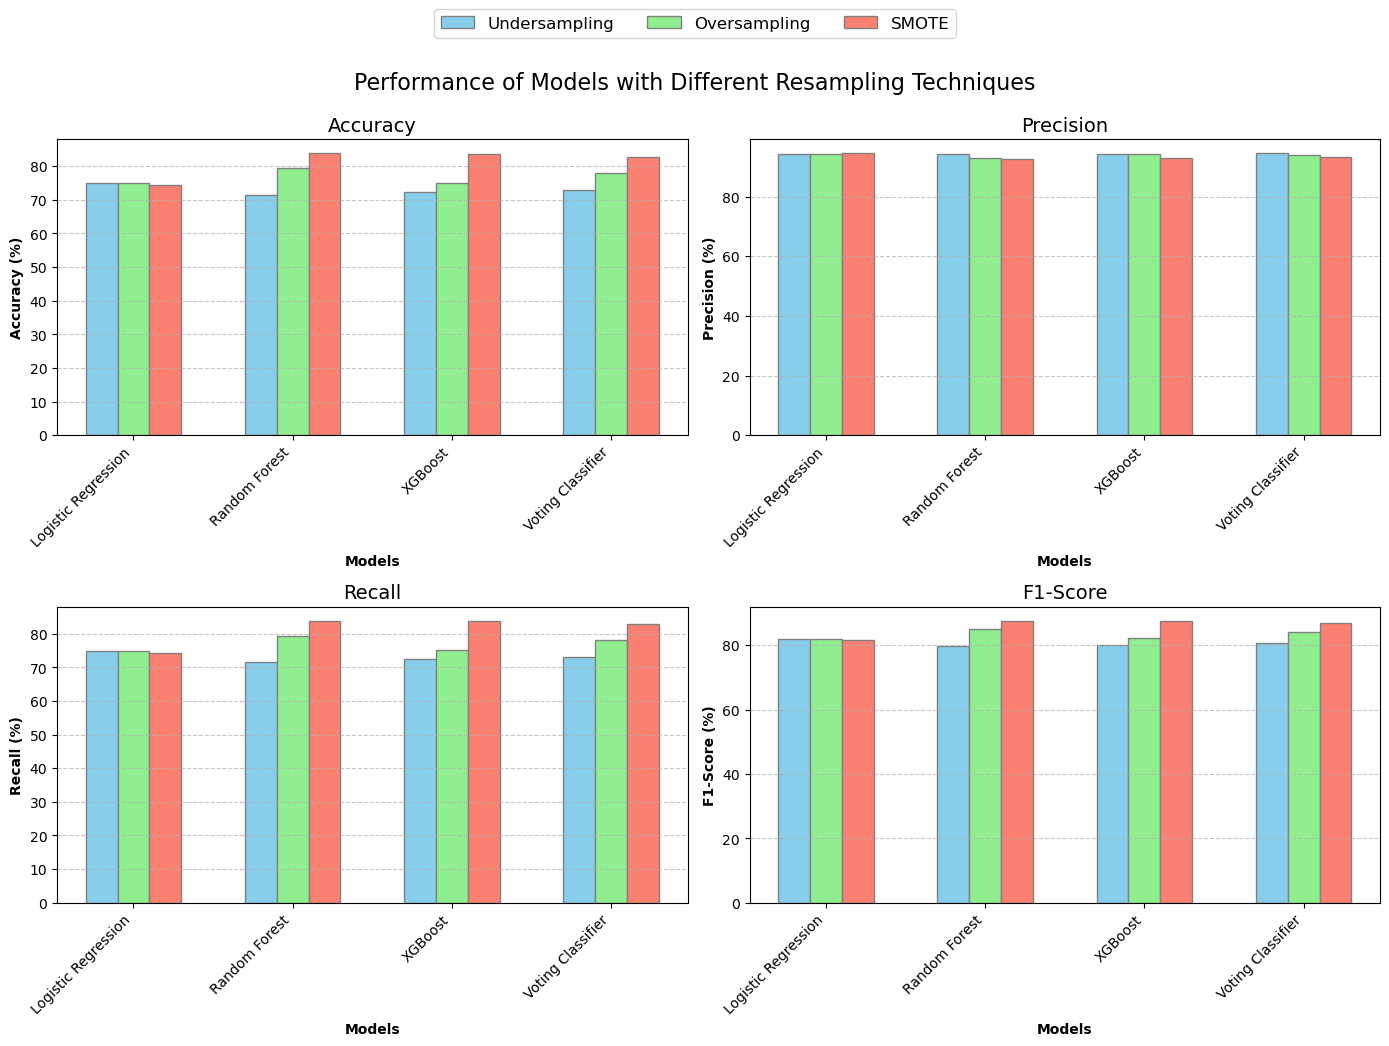

In [63]:

# Data and labels (same as before)
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Voting Classifier']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Data
undersampling = [
    [74.96, 94.43, 74.96, 82.02],  # Logistic Regression
    [71.59, 94.24, 71.59, 79.66],  # Random Forest
    [72.40, 94.43, 72.40, 80.24],  # XGBoost
    [72.97, 94.44, 72.97, 80.63],  # Voting Classifier
]
oversampling = [
    [75.02, 94.41, 75.02, 82.06],  # Logistic Regression
    [79.47, 93.07, 79.47, 84.91],  # Random Forest
    [75.16, 94.29, 75.16, 82.15],  # XGBoost
    [78.10, 93.99, 78.10, 84.11],  # Voting Classifier
]
smote = [
    [74.29, 94.46, 74.29, 81.56],  # Logistic Regression
    [83.82, 92.59, 83.82, 87.54],  # Random Forest
    [83.71, 93.03, 83.71, 87.57],  # XGBoost
    [82.76, 93.18, 82.76, 87.01],  # Voting Classifier
]

# Bar width
bar_width = 0.2

# Position of bars on x-axis
r1 = np.arange(len(models))

# Create a figure with 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

# Plot each metric separately for better visual comparison
for i, metric in enumerate(metrics):
    axes[i].bar(r1 - bar_width, [undersampling[j][i] for j in range(len(models))], color='skyblue', width=bar_width, edgecolor='grey', label='Undersampling')
    axes[i].bar(r1, [oversampling[j][i] for j in range(len(models))], color='lightgreen', width=bar_width, edgecolor='grey', label='Oversampling')
    axes[i].bar(r1 + bar_width, [smote[j][i] for j in range(len(models))], color='salmon', width=bar_width, edgecolor='grey', label='SMOTE')

    axes[i].set_xlabel('Models', fontweight='bold')
    axes[i].set_xticks(r1)
    axes[i].set_xticklabels(models, rotation=45, ha='right')
    axes[i].set_ylabel(f'{metric} (%)', fontweight='bold')
    axes[i].set_title(f'{metric}', fontsize=14)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the legend location to avoid overlap
fig.legend(['Undersampling', 'Oversampling', 'SMOTE'], loc='upper center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, 1.05))

# Adjust the layout and title to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle('Performance of Models with Different Resampling Techniques', fontsize=16)
plt.show()


/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:09:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:09:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


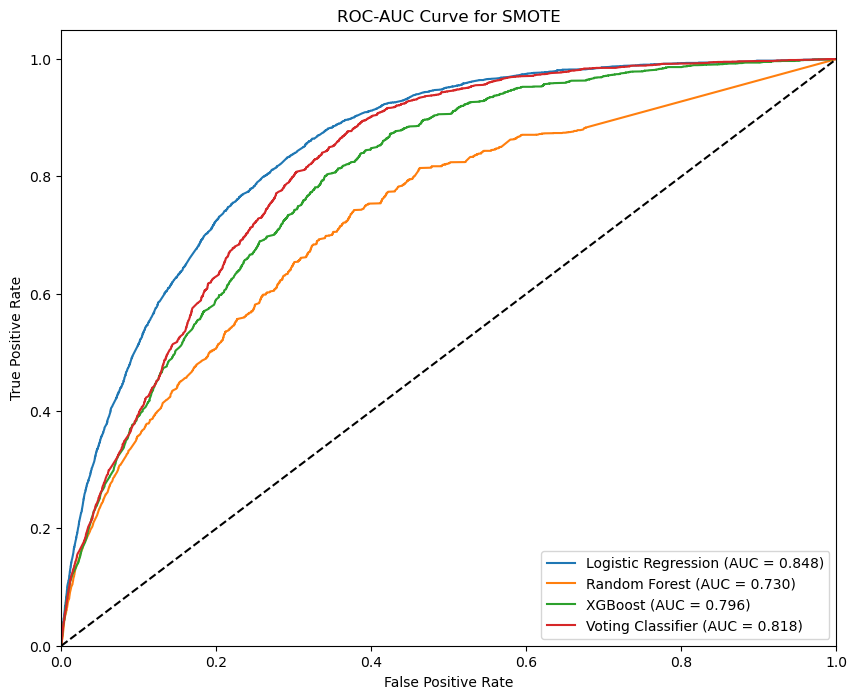

/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:10:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:10:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


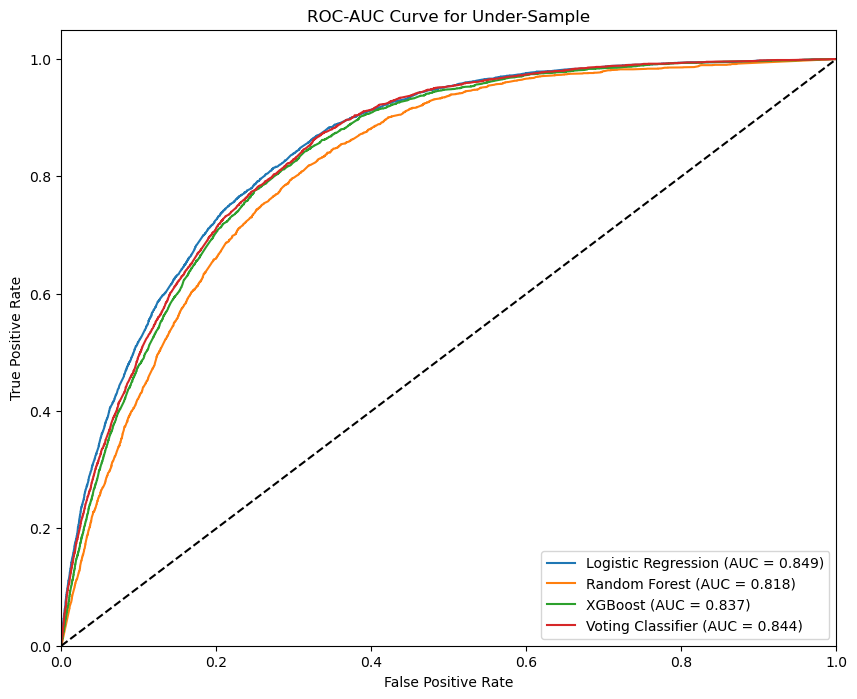

/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:10:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:10:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


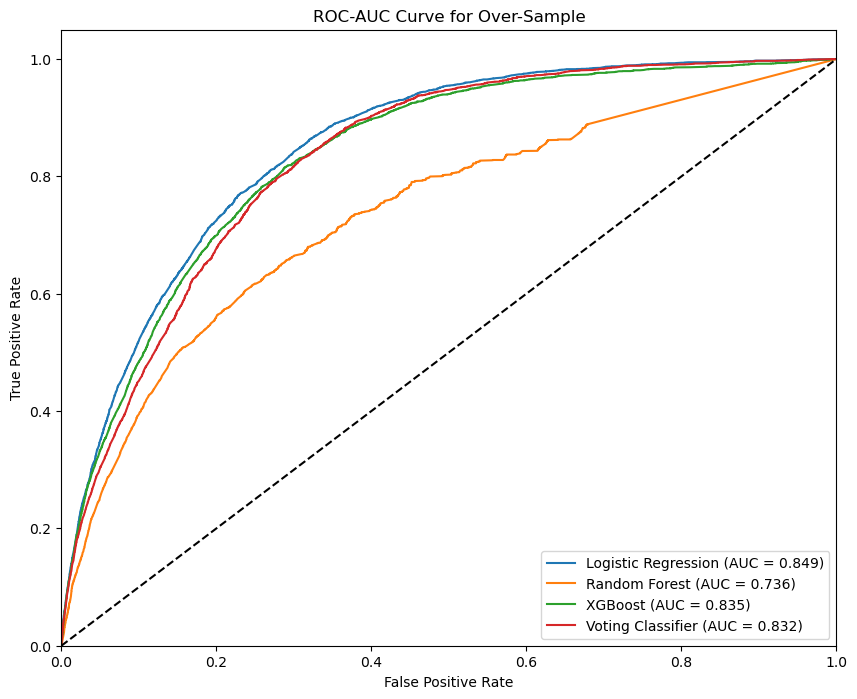

In [64]:
#ROC Curve
# Load the dataset
data = pd.read_csv('imbdata.csv')

# Data preprocessing
data.fillna(data.median(), inplace=True)

# Exclude 'Heart_Attack' and 'Heart_Disease' due to high correlation with the target
selected_features = ['Age_Group', 'Employment_Status', 'Stroke', 'High_Blood_Pressure', 
                     'High_Cholesterol', 'Diabetes', 'chronic_bronchitis', 'Kidney_Disease', 
                     'Arthritis', 'General_Health', 'Physical_Health', 'Difficuty_Walking']

# Feature and target separation using selected features
X = data[selected_features]
y = data['Coronary_Heart_Disease']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define resampling techniques
resampling_methods = {
    'SMOTE': SMOTE(random_state=42),
    'Under-Sample': RandomUnderSampler(random_state=42),
    'Over-Sample': RandomOverSampler(random_state=42)
}

# Initialize classifiers
models = {
    'Logistic Regression': LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=1,
        random_state=42
    ),
    'Voting Classifier': VotingClassifier(
        estimators=[
            ('log_reg', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', random_state=42)),
            ('rf_clf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')),
            ('xgb_clf', XGBClassifier(
                objective='binary:logistic',
                eval_metric='logloss',
                use_label_encoder=False,
                scale_pos_weight=1,
                random_state=42
            ))
        ],
        voting='soft'
    )
}

# Plotting ROC curves for each resampling technique
for method_name, resampler in resampling_methods.items():
    # Resample the training data
    X_train_resampled, y_train_resampled = resampler.fit_resample(X_train, y_train)

    # Feature scaling
    scaler = StandardScaler()
    X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # Plotting
    plt.figure(figsize=(10, 8))
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_resampled_scaled, y_train_resampled)
        
        # Predict probabilities
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Plot the ROC curve for this model
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    # Plot formatting
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-AUC Curve for {method_name}')
    plt.legend(loc='lower right')
    plt.show()


In [65]:
# Hyperparameter tuning uisng Smote for Voting Classifier
smote = SMOTE(random_state=42)

# Ensure we split the data first, and apply SMOTE only on the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to handle class imbalance in the training set only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale the resampled training data and test data
scaler = StandardScaler()
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Note: Scaling test data using the training scaler

# Simplified hyperparameter tuning for individual models
param_grid = {
    'log_reg__C': [0.1, 1],  # Fewer values for regularization strength
    'log_reg__penalty': ['l2'],  # Focus on L2 regularization only
    'rf_clf__n_estimators': [100],  # Fix the number of trees for Random Forest
    'rf_clf__max_depth': [10, None],  # Only test a couple of max depth options
    'xgb_clf__learning_rate': [0.1],  # Focus on one learning rate value for XGBoost
    'xgb_clf__max_depth': [3, 6],  # Only test two values for XGBoost max depth
}

# VotingClassifier with soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('rf_clf', rf_clf),
        ('xgb_clf', xgb_clf)
    ],
    voting='soft'
)

# GridSearchCV for hyperparameter tuning (using 3-fold cross-validation)
grid_search = GridSearchCV(
    estimator=voting_clf,
    param_grid=param_grid,
    cv=3,  # Reduced to 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1  # Use all processors for parallel computation
)

# Fit the GridSearchCV model on the resampled and scaled training data
grid_search.fit(X_train_resampled_scaled, y_train_resampled)

# Best hyperparameters and best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

# Evaluate on test set with the best found model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
class_report = classification_report(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.5f}")
print(f"Test ROC-AUC Score: {roc_auc:.5f}")
print("Classification Report:")
print(class_report)


/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dhananjayd/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:11:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

Best Hyperparameters: {'log_reg__C': 0.1, 'log_reg__penalty': 'l2', 'rf_clf__max_depth': None, 'rf_clf__n_estimators': 100, 'xgb_clf__learning_rate': 0.1, 'xgb_clf__max_depth': 6}
Best Cross-validation Score: 0.8669063797723228
Test Accuracy: 0.82610
Test ROC-AUC Score: 0.82411
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90     70978
         1.0       0.16      0.57      0.24      3656

    accuracy                           0.83     74634
   macro avg       0.56      0.71      0.57     74634
weighted avg       0.93      0.83      0.87     74634

